# Rede Neural para prever Aluguéis de Bicicletas

Rede neural desenvolvida sem a utilização de nenhum framework, usando apenas python, pandas e numpy

Base de dados utilizada:
    
Bike Sharing Dataset Data Set (https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

### 1-Importação dos módulos utilizados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 2- Carga e preparação dos dados

In [2]:
data_path = 'datasets/hour.csv'
df = pd.read_csv(data_path)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


2.1 - Criação de variáveis Summy

In [3]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix = each, drop_first = False)
    df = pd.concat([df, dummies], axis = 1)
    
colunas_para_deletar = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr']

data = df.drop(colunas_para_deletar, axis = 1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


2.2 - padronização dos dados

In [4]:
features_numericas = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}
for item in features_numericas:
    mean, std = data[item].mean(), data[item].std()
    scaled_features[item] = [mean, std]
    data.loc[:, item] = (data[item] - mean)/std

2.3 - dividindo o conjunto de dados

In [5]:
test_data = data[-21*24:]
data = data[:-21*24]

target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis = 1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis = 1), test_data[target_fields]

train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

### 3 - Construindo a Rede Neural

In [6]:
# Classe da Rede Neural
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate, verbose = False):
        
        # Defina o número de nós nas camadas de entrada, oculta e de saída.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Inicializando os pesos
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        self.verbose = verbose 
        
        if self.verbose:
            print("Rede Neural iniciada com:\ninput_nodes: {}\nhidden_nodes: {}\noutput_nodes: {}\nlearning_rate: {}\n".format(
                self.input_nodes, self.hidden_nodes, self.output_nodes, self.lr
            ))
        
        self.hidden_layer_activation_function = lambda x: 1 / (1 + np.exp(-x))
        self.hidden_layer_derivate_activation_function = lambda sigmoid: sigmoid * (1 - sigmoid)
        self.output_layer_activation_function = lambda x: x 
        self.output_layer_derivate_activation_function = lambda x: 1 
        
        # Ativação
        self.activation_function = self.hidden_layer_activation_function 
    
    def forward_pass(self, inputs):
        
        # Forward pass #
        
        # Sinais da camada de entrada
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) 
        
        # Sinais da camada oculta
        hidden_outputs = self.hidden_layer_activation_function(hidden_inputs) 
        
        # Sinais na camada de saída final
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) 
        final_outputs = self.output_layer_activation_function(final_inputs)
        return [hidden_inputs, hidden_outputs, final_inputs, final_outputs]
    
    def backward_pass(self, inputs, targets, hidden_inputs, hidden_outputs, final_inputs, final_outputs):
        
        # Backward pass #
        output_errors = targets - final_outputs
        output_grad = self.output_layer_derivate_activation_function(final_outputs)
        
        # Backpropagated error
        
        # Erros propagados para a camada oculta
        hidden_errors = output_errors * output_grad * self.weights_hidden_to_output 
        hidden_grad = self.hidden_layer_derivate_activation_function(hidden_outputs)
            
        return [output_errors, hidden_errors, hidden_grad, output_grad]

    def train(self, inputs_list, targets_list):
        
        # Converta a lista de entradas para a matriz 2d
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        hidden_inputs, hidden_outputs, final_inputs, final_outputs = self.forward_pass(inputs)
        output_errors, hidden_errors, hidden_grad, output_grad = self.backward_pass(inputs, targets, hidden_inputs, hidden_outputs, final_inputs, final_outputs)

        # Atualização de pesos para saída com passo de descida de gradiente
        self.weights_hidden_to_output += self.lr * np.dot(output_errors * output_grad, hidden_outputs.T) 
        self.weights_input_to_hidden += self.lr * np.dot(hidden_errors.T * hidden_grad, inputs.T)
 
    def run(self, inputs_list):
        # Executa um passo para a frente pela rede
        inputs = np.array(inputs_list, ndmin = 2).T
        
        _, _, _, final_outputs = self.forward_pass(inputs)
        return final_outputs

In [7]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

### 4 - Treinando a rede

In [8]:
import sys

epochs=3000
learning_rate = 0.1
hidden_nodes = 27
output_nodes = 1

N_i =train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate, True)

losses = {'train':[], 'validation':[]}

for e in range(epochs):
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']):
        network.train(record, target)
    
    # Imprimir o progresso do treinamento
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    
    sys.stdout.write("\rProgresso: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Erro no Treinamento: " + str(train_loss)[:5] \
                     + " ... Erro na Validação: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)
        

Rede Neural iniciada com:
input_nodes: 56
hidden_nodes: 27
output_nodes: 1
learning_rate: 0.1

Progresso: 99.9% ... Erro no Treinamento: 0.044 ... Erro na Validação: 0.151

### 5 - Plotando os erros encontrados

(-0.025432193196206661, 0.5)

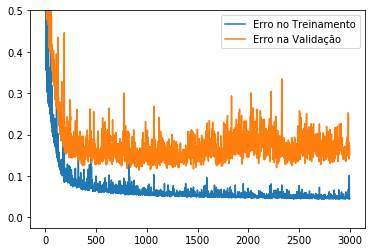

In [9]:
plt.plot(losses['train'], label = 'Erro no Treinamento')
plt.plot(losses['validation'], label = 'Erro na Validação')
plt.legend()
plt.ylim(ymax = 0.5)

### 6 - Fazendo as previsões 

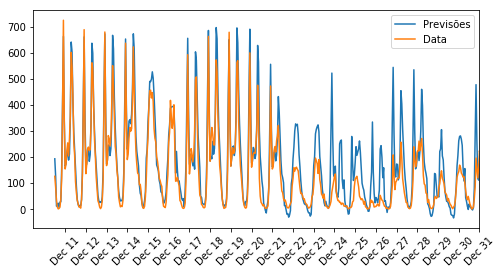

In [10]:
fig, ax = plt.subplots(figsize = (8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label = 'Previsões')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right = len(predictions))
ax.legend()

dates = pd.to_datetime(df.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)